<a href="https://colab.research.google.com/github/dlafarga/3D-Visualization-Tutorial-using-GLORYS/blob/main/3D_EOF_Plotting_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Vizualization for GLORYS EOFs
## Created by Danielle Lafarga 12/15/2025
This code can be used to visualize 3D climate data in 3D using matplotlib. As an example we use the first empirical orthogonal function (EOF) computed from the Global Ocean Physics Reanalysis (GLORYS) output for all latitude-longitude-depth dimensions (3D) at once. The complete calculation for the GLORYS 3D EOFs can be found at [this repository](https://github.com/dlafarga/PIM-for-Computing-3D-EOFs). For now, the EOF file is saved within this repository for conveniance.

The following is an outline of this code:

- ## Section 1: Import libraries and define functions
  - this section will import all necessary libraries and will define the functions that will save the dimension variables, read, and preprocess data.
- ## Section 2: Read in EOF
  - This section will read in the data using the functione in section 1. Be sure to change the directories accordingly.
- ## Section 3: Plot cross-sections in 3D
  - ### 3.1 Depth cross-section
    - plots the data for a single depth
  - ### 3.2 Zonal Cross-section
    - plots the data for a single latitude value
  - ### 3.3 Meridional Cross-section
    - plots the data for a single longitude value
  - ### 3.4 All cross-section plotted as cube
    - plots all previous cross-sections visualized together in a 3D cube
- ## Section 4: Making a GIF
  - this section uses the zonal cross-section code in a function to create a GIF of zonal cross-sections going up the California coast.

You can use this code as a base for plotting multiple cross-sections on one plot or mixing cross-sections.

# Section 1: Import libraries and define functions
Outline for functions used to read in and preprocess data:

- get_var: Used to read in the latitude, longitude, and depth variables of the data we are plotting. This is heavily dependent on the names of the variables in the data file.
- vol_weight: used to calculate the volume at each grid point. This is important to represent the dimensions right in the data, but is not necessary for plotting. **The EOF is weighted meaning the volume is multiplied in already,** this means we need to divide the volume out for visualization.
- read_EOFs: this reads in the data file and will divide out the volume at the end.

Outline of functions that format the figures:
- format_longitude and format_latitude: These remove the degree symbols for the axis labels of the figure.

In [ ]:
# all visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# to get path
import os

# libraries to read data
import netCDF4 as nc
from netCDF4 import Dataset as ds
import numpy as np

# libraries used for some math
from numpy import linspace
from numpy import meshgrid
import math

# Creating the custom colorbar
top2 = cm.get_cmap('GnBu_r')   # get green blue colormap
bottom2 = cm.get_cmap('hot_r') # get hot colormap
top_array = top2(np.linspace(0, 1, 128))        # create array with colorvalues
bottom_array = bottom2(np.linspace(0, .9, 128)) # create array with colorvalues
# edit array with color values to have better transition shades
top_array[-2:,:] = bottom_array[0,:]
top_array[-3,:] = np.array([1., 0.98823529, 1., 1.])
top_array[-4,:] = np.array([0.96862745, 0.98823529, 1., 1.])
top_array[-5,:] = np.array([0.96862745, 0.98823529, 0.94117647, 1.])

newcolors2 = np.vstack((top_array, bottom_array))         # stacking color arrays on top of each other
newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')   # creating new colormap

C:\Users\Dani\AppData\Local\Temp\ipykernel_28188\2635074327.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top2 = cm.get_cmap('GnBu_r')   # get green blue colormap
C:\Users\Dani\AppData\Local\Temp\ipykernel_28188\2635074327.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom2 = cm.get_cmap('hot_r') # get hot colormap


In [ ]:
#################################################################################################################
#################################################################################################################
# Function get_var() will get variables that will be required for EOFs
# Input:
#         - fn: a string with the complete path of the data
# Output:
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
#         - years: 1d array with all year values
# NOTE: Change variable names according to your file
def get_var(fn):
    fn     =  ds(fn,'r')
    lat    = fn.variables['lat'][:].data    # read in latitude
    lon    = fn.variables['lon'][:].data    # read in longitude
    depths = fn.variables['depth'][:].data  # read in depth
    fn.close()
    return lat, lon, depths
#################################################################################################################
#################################################################################################################
# Function compute volume weights based on latitude and depthe values. Although longitude values are not
# in the equation the length of the longitude array is necessary for building 3D volume weight array
# Input:
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
# Output:
#         - area_weight: 3D array with volume weight
def vol_weight(depths, lon, lat):
    xx, yy = meshgrid(lon, lat)
    tot_depth = len(depths)
    # area weight for lattitude values
    area_w = np.cos(yy*math.pi/180)
    if lat[-1] == 90.0:
        area_w[-1,:] = 0.0
    # volume weights for depth
    volume_weight = []
    for i in range(tot_depth):
        if i == 0:
            volume_weight.append(np.sqrt(depths[0] * area_w)) # first depth thickness
        else:
            volume_weight.append( np.sqrt((depths[i] - depths[i - 1]) * area_w))
    # Turning weights into one array
    volume_weight = np.array(volume_weight)
    return volume_weight
#################################################################################################################
#################################################################################################################
# Function will read one EOF mode
# Input:
#         - mode: (int) describing which mode to read
# Output:
#         - EOF: 3D float array with the EOF at a defined cut
def read_EOFs(fn):
  get_var(fn)
  EOF_ncfile = ds(fn, 'r')
  EOF = EOF_ncfile.variables['EOF']
  EOF = EOF[:].filled()
  EOF_ncfile.close()
  volume_weight = vol_weight(depths, lon, lat)
  EOF = EOF/volume_weight  # remember to div by volume weight
  return EOF
#################################################################################################################
#################################################################################################################
# Function formats longitude to get rid of degree symbols
# Input:
#         - longitude: int with longitude from 0 to 360
# Ouput:
#         - string with longitude value and W (west) or E (east)
def format_longitude(longitude):
    if not 0 <= longitude <= 360:
        return "Invalid longitude. Must be between 0 and 360 degrees."

    if longitude == 0:
        hemisphere = ''
        degrees = longitude
    elif longitude < 180:
        hemisphere = 'E'
        degrees = longitude
    elif longitude == 180:
        hemisphere = ''
        degrees = longitude
    else:
        hemisphere = 'W'
        degrees = 360 - longitude

    return f"{degrees:.0f}{hemisphere}"

#################################################################################################################
#################################################################################################################

# Function formats latitude to get rid of degree symbols
# Input:
#         - latitude: int with latitude in degrees. Positive values are N and negative are S.
# Output:
#         - string with absolute value of latitude and S or N
def format_latitude(latitude):
    if not -90 <= latitude <= 90:
        return "Invalid latitude. Must be between -90 and 90 degrees."
# adding S or N based on negative or positive value
    if latitude > 0:
        hemisphere = "N"
    elif latitude == 0:
        hemisphere = ""
    else:
        hemisphere = 'S'

    degrees = abs(latitude)

    return f"{degrees:.0f}{hemisphere}"


# Section 2: Read in EOF
**Please change the variable fn to the correct path**

In [ ]:
# define the complete path with the file name
data_directory = os.getcwd()
fn     = 'EOF_1.nc'
fn     = os.path.join(data_directory, fn)

lat, lon, depths = get_var(fn) # read variables
EOF1 = read_EOFs(fn) # read EOF 1

# Section 3: Plot cross-sections in 3D
There are is one main function that does most of the plotting. You can find the documentation of the function at https://matplotlib.org/stable/gallery/mplot3d/box3d.html.

For each of these plots assume:
- X-axis is longitude
- Y-axis is latitude
- Z-axis is depth

We define the variables **X, Y,** and **Z** as 3D arrays with their respective values that are cut down to a specific range. To do this we use the function meshgrid with the order longitude, latitude, and depth. The meshgrid is built from cut dimensions to focus on the North Pacific.

## 3.1 Depth cross-section
Heres how we use the main function for the depth cross-section:
```
ax.contourf(X[:,:,0], Y[:,:,0], data, zdir='z', offset=-depths[0], levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
```
**X** and **Y** are 3D arrays with longitude, latitude, and depth values (in that order) cut down to a specified region. The cut are defined as values that focus on the North Pacific:
```
lat_cut_start = 960    # index for the equator
lat_cut_end = 1681     # index for 60 N
lon_cut_start = 1920   # index for 160 E
lon_cut_end = 3601     # index for 60 W
depth_cut_end = 30     # index for 454
```

Since we are plotting on the Z axis the depth value remains constant for every variable hence calling indices $[:,:,0]$. The value 0 is arbitrary for these variables; technicaly, the **X** and **Y** values are the same for every depth.

**data** is a 2D array which comes from the **EOF** 3D array of size (depth, lat, lon). **The indexing is different for this array**, but either way it will hold depth constant.

Note: The data values are passed as the argument for the dimension that is held constant. In this case because it is depth, data is passed as the thrid argument.

The argument **zdir** is the direction the cross-section will be plot in. You will want to set **offset** as a number defined in this same direction. In our example because **zdir = 'z'** which is defined as depth, we set **offset** as the first depth value.

Note: We define the surface as 0. Anything above the surface would be positive and anything below the surface is negative. Since our data has its depth layers defined as going deeper we add a negative to the depth values when plotting.

The last 4 arguments have to do with the colorbar setting the colormap, norm mapping, the lower limit, and top limit of the colorbar, respectively.

In [17]:
# Set up cube for the North Pacific
lat_cut_start = 960    # index for the equator
lat_cut_end = 1681     # index for 60 N
lon_cut_start = 1920   # index for 160 E
lon_cut_end = 3601     # index for 60 W
depth_cut_end = 30     # index for 454

# creating the depth cross-section surface
surface3D = EOF1[0, lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]      # surface cross-section

# Defining the range and position of each tick for labeling
# last number changes the interval
lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end], 20)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end], 20)
depth_ticks = np.arange(0, depths[depth_cut_end], 100) # if plotting the first 100 meters change the last number to something =<25

# create grid for each lat, lon, and depth variable
X, Y, Z = np.meshgrid(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], -depths[0:depth_cut_end])


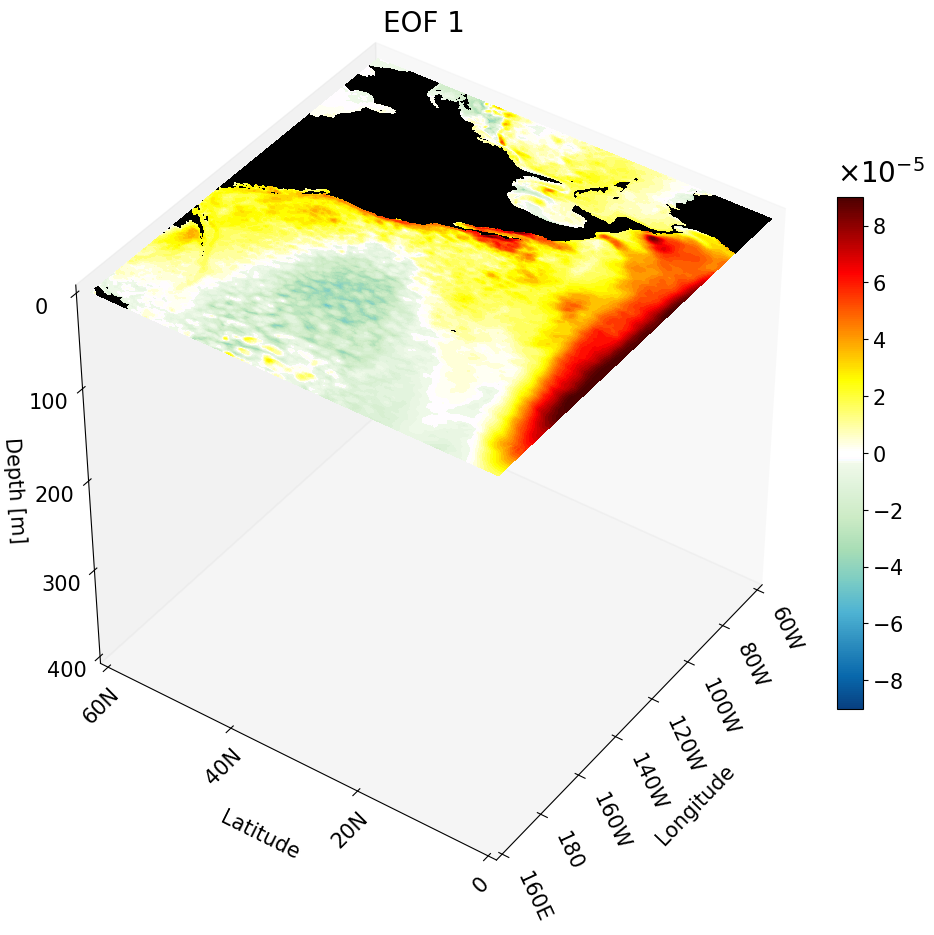

In [18]:
#############################################################################

# --- Setup Figure ---
fig = plt.figure(figsize=(11, 13))
title_sz = 20
label_sz = title_sz-5

ax = fig.add_subplot(111, projection='3d')  # This is what defines the plot as 3D
vmin, vmax = -0.00009, 0.00009              # Change to scale better
levels = 50                                 # set how many colors you want to plot

# Contour Norms
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#############################################################################
# plot the top of the box
# offset will place the cross-section in the right position on the Z axis
cs2 = ax.contourf(X[:, :, 0], Y[:, :, 0], surface3D, zdir='z', offset=-depths[0],
                  levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
# plotting land as black
mask = np.isnan(surface3D)                                                 # create a mask for the NaN values
masked_array = np.where(mask, surface3D, np.nan)                           # change points with values to NaN
end_of_map = np.nanmin(EOF1[31,lat_cut_start,lon_cut_start:lon_cut_end])   # minimum value to define bottom of map
masked_array = np.where(~mask, masked_array, end_of_map)                   # change NaN points to values
_ = ax.contourf(X[:, :, 0], Y[:, :, 0], masked_array, zdir='z', offset=-depths[0], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land as black

#############################################################################
# The following is VERY important
# It makes sure the bounds are defined accurately
# If your bounds are not defined well your plot will not show up!!!
# Formatting labels
ax.grid(False)
ax.set_xticks(lon_ticks, labels=[format_longitude(int(l)) for l in lon_ticks], fontsize=label_sz, rotation = -65, ha = 'left') # Requires format_longitude function to remove degree symbol
ax.set_yticks(lat_ticks, labels=[format_latitude(int(l)) for l in lat_ticks], fontsize=label_sz, rotation = 45)  # Requires format_latitude function to remove degree symbol
ax.set_zticks(-depth_ticks, labels=[f"{t:.0f}" for t in depth_ticks], fontsize=label_sz)
ax.tick_params(axis='x', pad=0, labelsize=label_sz)
ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
ax.tick_params(axis='z', pad=7,  labelsize=label_sz)


# Label Axes
ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=28)
ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=12, rotation=0)
ax.set_title("EOF 1", fontsize=title_sz)

# Set limits
ax.set_xlim(lon_ticks[0], lon_ticks[-1])
ax.set_ylim(lat_ticks[0], lat_ticks[-1])
ax.set_zlim(-depth_ticks[-1], 0)


#############################################################################

ax.set_box_aspect((1, 1, 1))
# view from above to make sure plot matches
ax.view_init(elev=40, azim=-145, vertical_axis='z')

#############################################################################
# the colorbar for the EOF data

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, format = mpl.ticker.ScalarFormatter(useMathText=True), norm = norm, fraction=0.03, pad = 0)
cbar.ax.yaxis.get_offset_text().set_fontsize(title_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

## 3.2 Zonal Cross-section
We use the same main function with a few changes to do a zonal cross-section.

```
ax.contourf(X[0, :, :], data, Z[0,:,:], zdir='y', offset = lat[lat_cut_start], levels=levels, cmap=newcmp2, norm=norm, vmin=vmin, vmax=vmax)
```

Now we hold the latitude consitant which is the first index of **X** and **Z**. All values are the same throughout the first index similar to the previous section. For consistency we wanted to plot the first cut value so we use the index **0**.

**zdir** and **offset** are also changed to reflect the positioning of the cross-section at the first latitude value for the North Pacific, **lat[lat_cut_start]**, in the y-axis.

In [26]:
# Set up cube for the North Pacific
lat_cut_start = 960    # index for the equator
lat_cut_end = 1681     # index for 60 N
lon_cut_start = 1920   # index for 160 E
lon_cut_end = 3601     # index for 60 W
depth_cut_end = 30     # index for 454

# creating the zonal cross-section surface
lat_depth3D = EOF1[:depth_cut_end , lat_cut_start, lon_cut_start:lon_cut_end] # zonal cross-section


# Defining the range and position of each tick for labeling
# last number changes the interval
lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end], 20)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end], 20)
depth_ticks = np.arange(0, depths[depth_cut_end], 100) # if plotting the first 100 meters change the last number to something =<25

# create grid for each lat, lon, and depth variable
X, Y, Z = np.meshgrid(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], -depths[0:depth_cut_end])

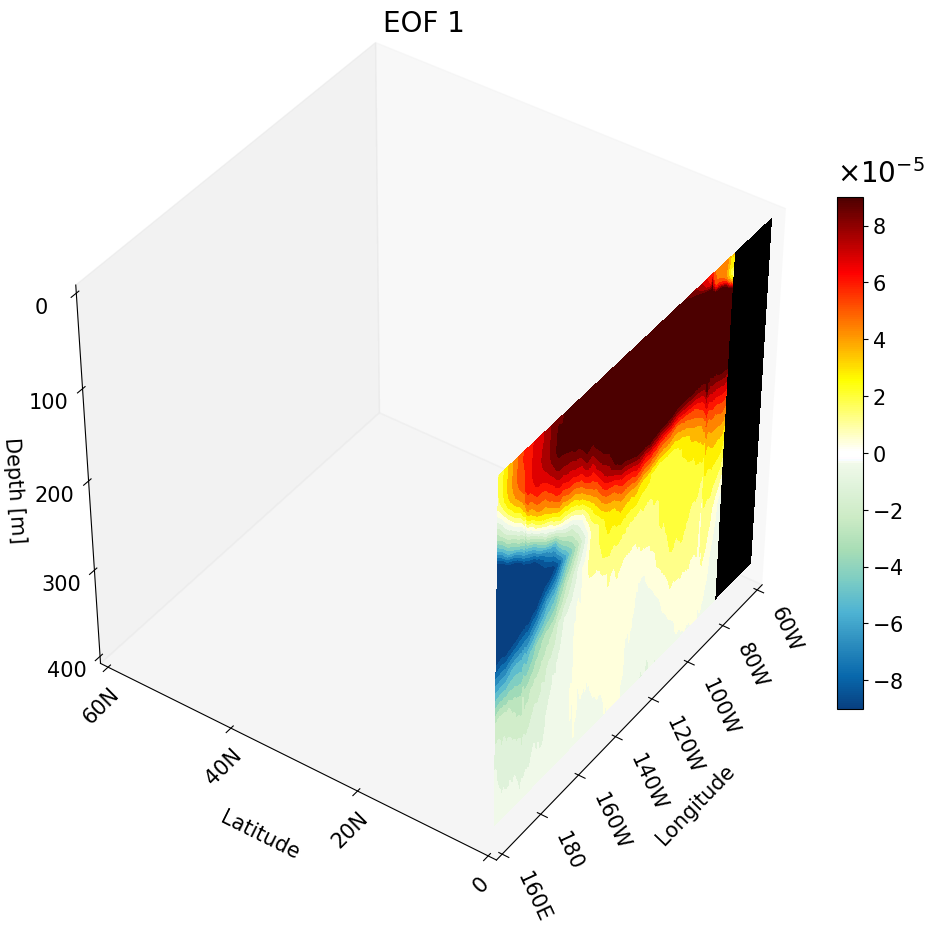

In [28]:
#############################################################################

# --- Setup Figure ---
fig = plt.figure(figsize=(11, 13))
title_sz = 20
label_sz = title_sz-5

ax = fig.add_subplot(111, projection='3d')  # This is what defines the plot as 3D
vmin, vmax = -0.00009, 0.00009              # Change to scale better
levels = 50                                 # set how many colors you want to plot

# Contour Norms
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#############################################################################
# Plot zonal cross-section
ax.contourf(X[0, :, :], lat_depth3D.T, Z[0,:,:], zdir='y', levels=levels, cmap=newcmp2, offset= lat[960],
            norm=norm, vmin=vmin, vmax=vmax)

# plotting land
mask = np.isnan(lat_depth3D)                                # create a mask for the NaN values
masked_array = np.where(mask, lat_depth3D, np.nan)          # change points with values to NaN
masked_array = np.where(~mask, masked_array, vmin)          # change NaN points to values
_ = ax.contourf(X[0, :, :], masked_array.T, Z[0,:,:], zdir='y', offset=lat[960], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land

#############################################################################
# The following is VERY important
# It makes sure the bounds are defined accurately
# If your bounds are not defined well your plot will not show up!!!
# Formatting labels
ax.grid(False)
ax.set_xticks(lon_ticks, labels=[format_longitude(int(l)) for l in lon_ticks], fontsize=label_sz, rotation = -65, ha = 'left') # Requires format_longitude function to remove degree symbol
ax.set_yticks(lat_ticks, labels=[format_latitude(int(l)) for l in lat_ticks], fontsize=label_sz, rotation = 45)  # Requires format_latitude function to remove degree symbol
ax.set_zticks(-depth_ticks, labels=[f"{t:.0f}" for t in depth_ticks], fontsize=label_sz)
ax.tick_params(axis='x', pad=0, labelsize=label_sz)
ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
ax.tick_params(axis='z', pad=7,  labelsize=label_sz)


# Label Axes
ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=28)
ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=12, rotation=0)
ax.set_title("EOF 1", fontsize=title_sz)

# Set limits
ax.set_xlim(lon_ticks[0], lon_ticks[-1])
ax.set_ylim(lat_ticks[0], lat_ticks[-1])
ax.set_zlim(-depth_ticks[-1], 0)


#############################################################################

ax.set_box_aspect((1, 1, 1))
# view from above to make sure plot matches
ax.view_init(elev=40, azim=-145, vertical_axis='z')

#############################################################################
# the colorbar for the EOF data

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, format = mpl.ticker.ScalarFormatter(useMathText=True), norm = norm, fraction=0.03, pad = 0)
cbar.ax.yaxis.get_offset_text().set_fontsize(title_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

## 3.3 Meridional Cross-section
We use the same main function with a few changes to do a zonal cross-section.

```
ax.contourf(data, Y[:,0,:], Z[:,0,:], zdir='x', offset = offset=lon_ticks[0], levels=levels, cmap=newcmp2, norm=norm, vmin=vmin, vmax=vmax)
```

Now we hold the longitude consitant which is the second index of **X** and **Z**.

**zdir** and **offset** are also changed to reflect the positioning of the cross-section in the x-axis.

In [ ]:
# Set up cube for the North Pacific
lat_cut_start = 960    # index for the equator
lat_cut_end = 1681     # index for 60 N
lon_cut_start = 1920   # index for 160 E
lon_cut_end = 3601     # index for 60 W
depth_cut_end = 30     # index for 454

# creating the cross-section surfaces
lon_depth3D = EOF1[:depth_cut_end , lat_cut_start:lat_cut_end, lon_cut_start] # meridional cross-section

# Defining the range and position of each tick for labeling
# last number changes the interval
lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end], 20)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end], 20)
depth_ticks = np.arange(0, depths[depth_cut_end], 100) # if plotting the first 100 meters change the last number to something =<25

# create grid for each lat, lon, and depth variable
X, Y, Z = np.meshgrid(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], -depths[0:depth_cut_end])

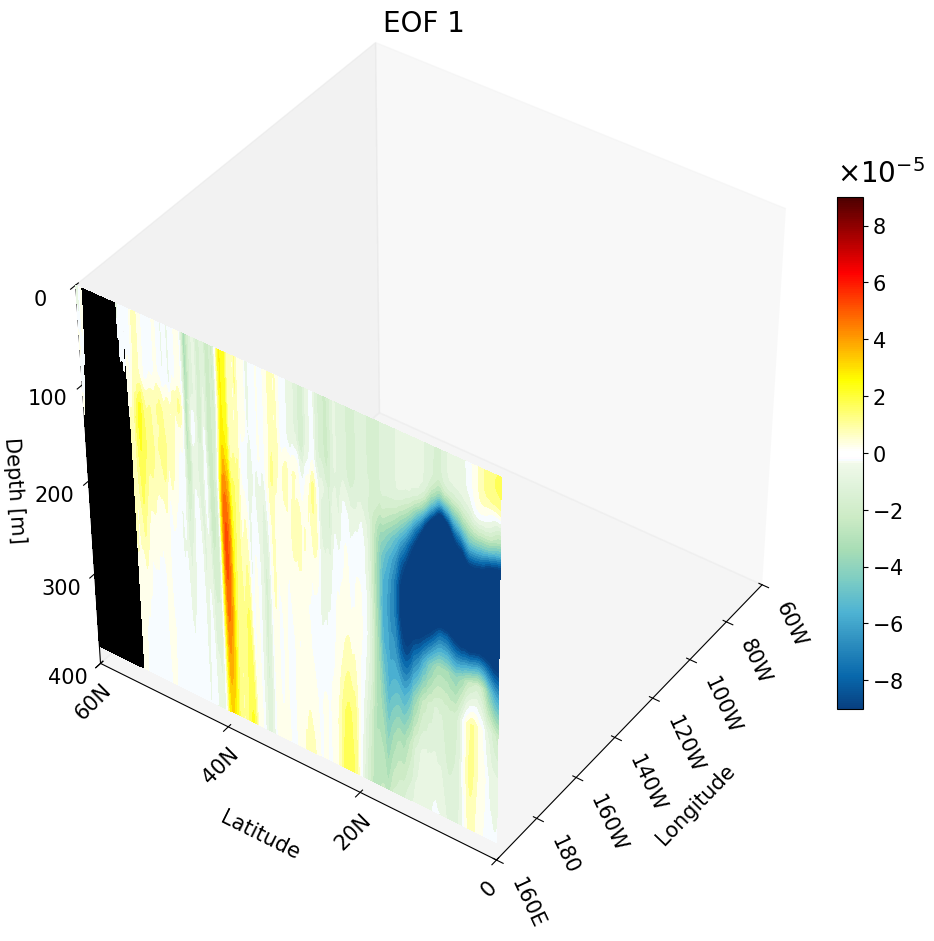

In [ ]:
#############################################################################

# --- Setup Figure ---
fig = plt.figure(figsize=(11, 13))
title_sz = 20
label_sz = title_sz-5

ax = fig.add_subplot(111, projection='3d')  # This is what defines the plot as 3D
vmin, vmax = -0.00009, 0.00009              # Change to scale better
levels = 50                                 # set how many colors you want to plot

# Contour Norms
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#############################################################################
ax.contourf(lon_depth3D.T, Y[:, 0, :], Z[:, 0, :], zdir='x', offset=lon_ticks[0], levels=levels,
            cmap=newcmp2, norm=norm, vmin=vmin, vmax=vmax)

# plotting land
mask = np.isnan(lon_depth3D) # create a mask for the NaN values
masked_array = np.where(mask, lon_depth3D, np.nan)          # change points with values to NaN
masked_array = np.where(~mask, masked_array, vmin) # change NaN points to values
_ = ax.contourf(masked_array.T, Y[:, 0, :], Z[:, 0, :], zdir='x', offset=lon_ticks[0], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land

#############################################################################
# The following is VERY important
# It makes sure the bounds are defined accurately
# If your bounds are not defined well your plot will not show up!!!
# Formatting labels
ax.grid(False)
ax.set_xticks(lon_ticks, labels=[format_longitude(int(l)) for l in lon_ticks], fontsize=label_sz, rotation = -65, ha = 'left') # Requires format_longitude function to remove degree symbol
ax.set_yticks(lat_ticks, labels=[format_latitude(int(l)) for l in lat_ticks], fontsize=label_sz, rotation = 45)  # Requires format_latitude function to remove degree symbol
ax.set_zticks(-depth_ticks, labels=[f"{t:.0f}" for t in depth_ticks], fontsize=label_sz)
ax.tick_params(axis='x', pad=0, labelsize=label_sz)
ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
ax.tick_params(axis='z', pad=7,  labelsize=label_sz)


# Label Axes
ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=28)
ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=12, rotation=0)
ax.set_title("EOF 1", fontsize=title_sz)

# Set limits
ax.set_xlim(lon_ticks[0], lon_ticks[-1])
ax.set_ylim(lat_ticks[0], lat_ticks[-1])
ax.set_zlim(-depth_ticks[-1], 0)


#############################################################################

ax.set_box_aspect((1, 1, 1))
# view from above to make sure plot matches
ax.view_init(elev=40, azim=-145, vertical_axis='z')

#############################################################################
# the colorbar for the EOF data

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, format = mpl.ticker.ScalarFormatter(useMathText=True), norm = norm, fraction=0.03, pad = 0)
cbar.ax.yaxis.get_offset_text().set_fontsize(title_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

## 3.4 All cross-section plotted as cube

In [29]:
# Set up cube for the North Pacific
lat_cut_start = 960    # index for the equator
lat_cut_end = 1681     # index for 60 N
lon_cut_start = 1920   # index for 160 E
lon_cut_end = 3601     # index for 60 W
depth_cut_end = 30     # index for 454

# creating the cross-section surfaces
surface3D = EOF1[0, lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]      # surface cross-section
lat_depth3D = EOF1[:depth_cut_end , lat_cut_start, lon_cut_start:lon_cut_end] # zonal cross-section
lon_depth3D = EOF1[:depth_cut_end , lat_cut_start:lat_cut_end, lon_cut_start] # meridional cross-section

# Defining the range and position of each tick for labeling
# last number changes the interval
lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end], 20)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end], 20)
depth_ticks = np.arange(0, depths[depth_cut_end], 100) # if plotting the first 100 meters change the last number to something =<25

# create grid for each lat, lon, and depth variable
X, Y, Z = np.meshgrid(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], -depths[0:depth_cut_end])

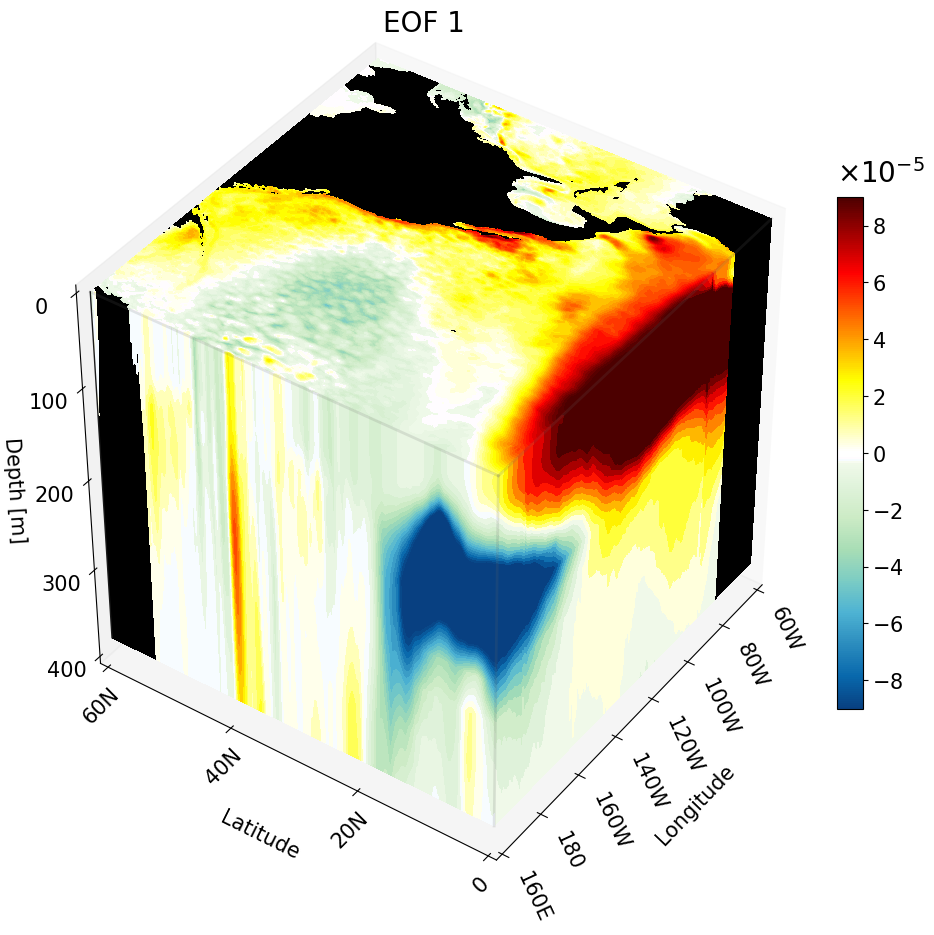

In [31]:
lat_cut_start = 960
lat_cut_end = 1681
lon_cut_start =1920
lon_cut_end = 3601
depth_cut_end = 30

# 3D EOF
surface3D = EOF1[0, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end]
lat_depth3D = EOF1[:depth_cut_end , lat_cut_start, lon_cut_start:lon_cut_end]
lon_depth3D = EOF1[:depth_cut_end , lat_cut_start:lat_cut_end, lon_cut_start]

lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end], 20)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end], 20)
depth_ticks = np.arange(0, depths[depth_cut_end], 100)

# create grid to plot in x and z for the y cross section
X, Y, Z = np.meshgrid(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], -depths[0:depth_cut_end])

#############################################################################depth_ticksticksut the regions to be only the California Coast


# --- Setup Figure ---
fig = plt.figure(figsize=(11, 13))
title_sz = 20
label_sz = title_sz-5

ax = fig.add_subplot(111, projection='3d')
vmin, vmax = -0.00009, 0.00009 # Change to scale better
levels = 50

# Contours
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#############################################################################
# plotting depth cross-section
# plotting the contours at the surface
cs2 = ax.contourf(X[:, :, 0], Y[:, :, 0], surface3D, zdir='z', offset=-depths[0],
                  levels=levels, cmap=newcmp2, norm=norm,vmin=vmin, vmax=vmax)
# plotting land
mask = np.isnan(surface3D) # create a mask for the NaN values
masked_array = np.where(mask, surface3D, np.nan)          # change points with values to NaN
end_of_map   = np.nanmin(EOF1[31,lat_cut_start,lon_cut_start:lon_cut_end]) # minimum value to define bottom of map
masked_array = np.where(~mask, masked_array, end_of_map)  # change NaN points to values
_ = ax.contourf(X[:, :, 0], Y[:, :, 0], masked_array, zdir='z', offset=-depths[0], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land

#############################################################################
# plotting zonal cross-section
# plotting the contours at the equator
ax.contourf(X[0, :, :], lat_depth3D.T, Z[0,:,:], zdir='y', levels=levels, cmap=newcmp2, offset= 0,
            norm=norm, vmin=vmin, vmax=vmax)
# plotting land
mask = np.isnan(lat_depth3D) # create a mask for the NaN values
masked_array = np.where(mask, lat_depth3D, np.nan)      # change points with values to NaN
masked_array = np.where(~mask, masked_array, vmin)      # change NaN points to values
_ = ax.contourf(X[0, :, :], masked_array.T, Z[0,:,:], zdir='y', offset=0, cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land

#############################################################################
# plotting meridional cross-section
# plotting contours at 160E
ax.contourf(lon_depth3D.T, Y[:, 0, :], Z[:, 0, :], zdir='x', offset=lon_ticks[0], levels=levels,
            cmap=newcmp2, norm=norm, vmin=vmin, vmax=vmax)

# plotting land
mask = np.isnan(lon_depth3D) # create a mask for the NaN values
masked_array = np.where(mask, lon_depth3D, np.nan)          # change points with values to NaN
masked_array = np.where(~mask, masked_array, vmin) # change NaN points to values
_ = ax.contourf(masked_array.T, Y[:, 0, :], Z[:, 0, :], zdir='x', offset=lon_ticks[0], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
#############################################################################
# formatting axis
ax.grid(False)
ax.set_xticks(lon_ticks, labels=[format_longitude(int(l)) for l in lon_ticks], fontsize=label_sz, rotation = -65, ha = 'left') # Requires format_longitude function to remove degree symbol
ax.set_yticks(lat_ticks, labels=[format_latitude(int(l)) for l in lat_ticks], fontsize=label_sz, rotation = 45)  # Requires format_latitude function to remove degree symbol
ax.set_zticks(-depth_ticks, labels=[f"{t:.0f}" for t in depth_ticks], fontsize=label_sz)
ax.tick_params(axis='x', pad=0, labelsize=label_sz)
ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
ax.tick_params(axis='z', pad=7,  labelsize=label_sz)



ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=28)
ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=12, rotation=0)
ax.set_title("EOF 1", fontsize=title_sz)

ax.set_xlim(lon_ticks[0], lon_ticks[-1])
ax.set_ylim(lat_ticks[0], lat_ticks[-1])
ax.set_zlim(-depth_ticks[-1], 0)



ax.set_box_aspect((1, 1, 1))
# view from above to make sure plot matches
ax.view_init(elev=40, azim=-145, vertical_axis='z')

# appearance and formatting
#############################
# draw edges of 3d box
#############################
edges_kw = dict(color='0.4', linewidth=2, zorder=100, alpha = .16)



# Soft line edges for the cube
ax.plot(
    [lon[lon_cut_start], lon[lon_cut_end]],
    [lat[lat_cut_start], lat[lat_cut_start]],
    [-depths[0], -depths[0]],
    **edges_kw
)

ax.plot(
    [lon[lon_cut_start], lon[lon_cut_start]],
    [lat[lat_cut_start], lat[lat_cut_end]],
    [-depths[0], -depths[0]],
    **edges_kw
)

ax.plot(
    [lon[lon_cut_start], lon[lon_cut_start]],
    [lat[lat_cut_start], lat[lat_cut_start]],
    [-depths[0], -depths[depth_cut_end-1]],
    **edges_kw
)
# depth axis line so it is obvious
ax.plot(
    [lon[lon_cut_start], lon[lon_cut_start]],
    [lat[lat_cut_end], lat[lat_cut_end]],
    [-depths[0], -depths[depth_cut_end-1]],
    **dict(color='0.1', linewidth=1, zorder=100)
)


#ax.zaxis.line.set_linewidth(1.5)

#############################################################################
# the colorbar for the EOF data

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, format = mpl.ticker.ScalarFormatter(useMathText=True), norm = norm, fraction=0.03, pad = 0)
cbar.ax.yaxis.get_offset_text().set_fontsize(title_sz) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()

# Section 4: Making a GIF

In [1]:
#############################################################################
#############################################################################
# Function will plot one zonal cross-section for a region
# Input
#         - title: string with tite for each figure
#         - EOF: 3D array with data to be visualized
#         - clip: float clip value that defines maximum and minimum for the colorbar
#         - lat_ind: int with the latitude index that defines the cross-section
# Output
#         - fig: matplotlib figure object with the 3D figure
# Important variables
#         - lon_cut_start: int with starting longitude index
#         - lon_cut_end: int with end longitude index
#         - depth_cut_end: int with end depth index 
# Note: make sure all tick values are defined before calling this function. This is 
#       important for accurate labeling
#############################################################################
#############################################################################

def plot_zonal_3D(title, EOF, clip, lat_ind):
    
   
  # --- Setup Figure ---
  fig = plt.figure(figsize=(12, 13))
  fig.subplots_adjust(right = .95)  # Add this line

  title_sz = 20
  label_sz = title_sz-3

  ax = fig.add_subplot(111, projection='3d')  # This is what defines the plot as 3D
  vmin, vmax = -clip, clip                    # Change to scale better
  levels = 50                                 # set how many colors you want to plot

  # Contour Norms
  norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

  #############################################################################
  # plotting land
  surface3D = EOF[0, lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
  
  mask = np.isnan(surface3D) # create a mask for the NaN values
  masked_array = np.where(mask, surface3D, np.nan)          # change points with values to NaN
  masked_array = np.where(~mask, masked_array, vmin) # change NaN points to values
  _ = ax.contourf(X[:, :, 0], Y[:, :, 0], masked_array, zdir='z', offset=-depths[0], cmap = mpl.colors.ListedColormap(['black']) ) # plotting the land
  # Contours
  #############################################################################
  # plotting the cross-section
  lat_depth3D = EOF[:depth_cut_end , lat_ind, lon_cut_start:lon_cut_end] # define the cross-section from the cut and index

  # plot the cross-section contour
  C = ax.contourf(X[0, :, :], lat_depth3D.T, Z[0,:,:], zdir='y', levels=levels, cmap=newcmp2, offset= lat[lat_ind],
              norm=norm, vmin=vmin, vmax=vmax)
  #############################################################################
  ax.grid(True)
  ax.set_xticks(lon_ticks, labels=[format_longitude(int(l)) for l in lon_ticks], fontsize=label_sz, rotation = -65, ha = 'left')  # Requires format_longitude function to remove degree symbol
  ax.set_yticks(lat_ticks, labels=[format_latitude(int(l)) for l in lat_ticks], fontsize=label_sz, rotation = 45, va = 'center')  # Requires format_latitude function to remove degree symbol
  ax.set_zticks(-depth_ticks, labels=[f"{t:.0f}" for t in depth_ticks], fontsize=label_sz)
  ax.tick_params(axis='x', pad=0, labelsize=label_sz)
  ax.tick_params(axis='y', pad=6,  labelsize=label_sz)
  ax.tick_params(axis='z', pad=7,  labelsize=label_sz)

  ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=47)
  ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
  ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=14, rotation=0)
  ax.set_title(title, fontsize=title_sz)

  # Set limits
  ax.set_xlim(lon_ticks[0], lon_ticks[-1])
  ax.set_ylim(lat_ticks[0], lat_ticks[-1])
  ax.set_zlim(-depth_ticks[-1], 0)

  #############################################################################
  ax.set_box_aspect((1, 1, 1))

  # view from above to make sure plot matches
  ax.view_init(elev=40, azim=-150, vertical_axis='z')
  #############################################################################
  # the colorbar for the EOF data
  sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
  sm.set_array([])

  cbar = fig.colorbar(sm, ax=ax, format = mpl.ticker.ScalarFormatter(useMathText=True), norm = norm, fraction=0.03, pad = .05)
  cbar.ax.yaxis.get_offset_text().set_fontsize(title_sz) # change exp size
  cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
  cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left
  cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
  cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
  cbar.update_ticks()
  #############################################################################
 
  return fig 

In [2]:
# Set up cube for the North Pacific
lat_cut_start = 1320   # index for 30 N
lat_cut_end = 1537     # index for 48 N
lon_cut_start = 2760   # index for 130 W
lon_cut_end = 3013     # index for 109 W
depth_cut_end = 30     # index for 400

# Defining the range and position of each tick for labeling
# last number changes the interval
lon_ticks   = np.arange(lon[lon_cut_start], lon[lon_cut_end], 3)
lat_ticks   = np.arange(lat[lat_cut_start], lat[lat_cut_end], 3)
depth_ticks = np.arange(0, depths[depth_cut_end], 100) # if plotting the first 100 meters change the last number to something =<25

# create grid for each lat, lon, and depth variable
X, Y, Z = np.meshgrid(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], -depths[0:depth_cut_end])

# create cross-section figures and save as PNG
clip = 0.00009
title = 'EOF 1'
data  = EOF1
lat_indices = np.arange(lat_cut_start, lat_cut_end, 6)
pic_directory = data_directory
for i, lat_ind in enumerate(lat_indices):
    fig = plot_zonal_3D(title, data, clip, lat_ind)
    fn     = 'EOF1_Zonal_Cross_Section' + str(i) + '.png'
    fn     = os.path.join(pic_directory, fn)
    plt.savefig(fn, dpi=300, bbox_inches='tight')
    plt.close(fig)

NameError: name 'np' is not defined

In [ ]:
# create GiF
import imageio
from PIL import Image
import glob

gif_path = data_directory # set GIF path
frame_files = []
# call all cross-section figures saved
for i in range(len(lat_indices)):
  fn     = 'EOF1_Zonal_Cross_Section' + str(i) + '.png'
  fn     = os.path.join(data_directory, fn)
  frame_files.append(fn)

output_path = os.path.join(gif_path, f'{title}_animation.gif') # give gif a name based on title

frames = [Image.open(frame).convert('RGB') for frame in frame_files] # put all figs together
# save figs
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=200,
    loop=0,
    optimize=False,  # Don't compress
    quality=500  # Maximum quality
)

# Delete the PNG files
for file in frame_files:
    os.remove(file)

print(f"{output_path} created!")

C:\Users\Dani\Documents\GitHub\3D-Visualization-Tutorial-using-GLORYS\EOF 1_animation.gif created!


**The resulting zonal cross-section GIF**

<img src="https://raw.githubusercontent.com/dlafarga/3D-Visualization-Tutorial-using-GLORYS/main/EOF1_animation.gif" width="50%">